## Zadanie - klasyczna detekcja obiektów

Celem tego zadania jest własnoręczne zbudowanie, debugowanie i przetestowanie przez Ciebie prostego pipeline'u do rozpoznawania obiektów opartego o klasyczne metody przetwarzania obrazów.

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from typing import Any, List

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Twoim zadaniem będzie zaproponowanie algorytmu detekcji, który przyjmie obraz wejściowy i wykryje na nim obiekty - poszczególne tabletki, zwracając informację o ich położeniach i gatunkach.
Reprezentacja tej informacji jest dowolna: pary koordynat (X,Y) środka obiektu, bounding boksy (XYHW), czy kontury - istotne jest jedynie, by liczba detekcji możliwie dobrze zgadzała się ze stanem faktycznym.

Zadanie ma charakter projektowy i nie jest podzielone na szczegółowo opisane podpunkty, ponieważ można do niego podejść na różne sposoby (czytaj dalej).

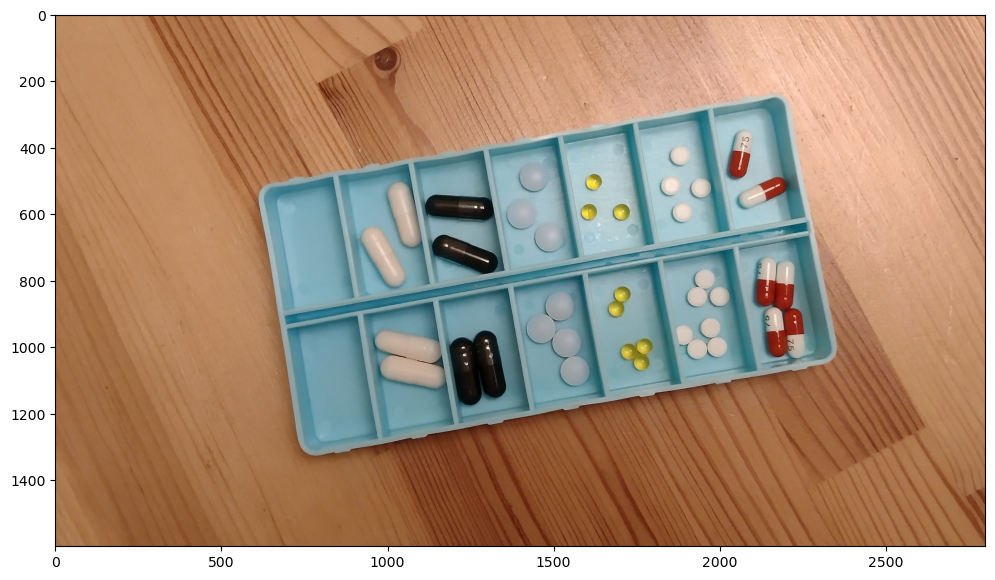

In [12]:
calib = cv2.imread('Lab5_dane/calib.png')
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib[..., ::-1]);

Występuje 6 klas obiektów; patrząc na organizer od lewej:

In [13]:
class PillType(Enum):
    PROBIO = 1    # duże białe kapsułki
    CARBON = 2    # duże czarne kapsułki
    KETO = 3      # niebieskie tabletki
    ESPU = 4      # małe żółte kapsułki
    BIOX = 5      # małe białe tabletki
    LINE = 6      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

Górny rząd zawiera łatwiejsze przykłady pojedynczych instancji, podczas gdy w rzędzie dolnym obiekty stykają się ze sobą, co utrudnia identyfikację.
Jak widzisz, nie wszystkie klasy są tak samo "wdzięczne" do wykrycia.
Nie próbuj zatem robić wszystkiego naraz - rekomendowane jest podejście sekwencyjne: najpierw zaimplementuj algorytm detekcji dla jednej klasy, przetestuj go i napraw, rozszerz o możliwość detekcji stykających się obiektów (_jak to zrobić?_), a dopiero potem podejmij kolejną klasę.

Wykorzystaj narzędzia poznane do tej pory (konwersje przestrzeni barw, binaryzację, detekcję krawędzi, etc.) by sprowadzić obraz do takiej postaci, w której detekcję interesujących obiektów będzie można wykonać za pomocą zwyczajnej ekstrakcji komponentów spójności - [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0).
Wspomóż się operacjami morfologicznymi jeśli to potrzebne, i nie wahaj się stosować jakichkolwiek narzędzi jakie znajdziesz -
wszystkie chwyty są dozwolone, za wyjątkiem stosowania metod MLowych.

W zależności od wybranej reprezentacji wykrytych obiektów, zaimplementuj metodę wizualizacji wyników.

Nie usuwaj notebooka, w którym będziesz debugować algorytm!
Przyda się podczas rozmowy, jeśli zajdzie konieczność wyjaśnienia dlaczego twój algorytm popełnia błędy - możliwość pokazania krok po kroku wykonywanych operacji będzie istotna.

### Rozwiązanie:

In [14]:
class Pill:
    """Output of object detection, represents a single instance"""
    def __init__(self, pill_type: PillType, location: Any):
        self.type = pill_type
        self.location = location

In [15]:
def find_circles(img: np.ndarray, min_radius: int = 0, max_radius: int = 0) -> List[Any]:
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=10,minRadius=min_radius,maxRadius=max_radius)
    return np.uint16(np.around(circles))

def delete_background(image: np.ndarray) -> np.ndarray:
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h = hsv[..., 0]

    _, mask_pills = cv2.threshold(h, 30, 255, cv2.THRESH_BINARY_INV) # pills

    mask_only_box = cv2.morphologyEx(mask_pills, cv2.MORPH_OPEN, np.ones((11, 11), np.uint8), iterations=22)

    masked = cv2.bitwise_and(image, image, mask=mask_pills)

    # if we want to detect pill outside the box
    masked = cv2.bitwise_and(masked, masked, mask=cv2.bitwise_not(mask_only_box))

    return masked

def detect_espu(image: np.ndarray) -> List:
    image = image.copy()
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h = hsv[..., 0]

    yellow = cv2.inRange(h, 20, 40)
    yellow = cv2.morphologyEx(yellow, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=8)
    circles = find_circles(yellow, 10, 27)

    return [Pill(PillType.ESPU, (x-r, y-r, 2*r, 2*r)) for x, y, r in circles[0]]


def detect_biox(image: np.ndarray) -> np.ndarray:
    image_copy = delete_background(image.copy())

    lab_masked = cv2.cvtColor(image_copy, cv2.COLOR_BGR2LAB)
    l = lab_masked[..., 0]

    _, mask = cv2.threshold(l, 160, 255, cv2.THRESH_BINARY)

    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=3)

    erosion_iterations = 6
    eroded = cv2.erode(opened, np.ones((3, 3), np.uint8), iterations=erosion_iterations)

    conts, _ = cv2.findContours(eroded, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

    def logic_expression(c: Any) -> bool:
            x, y, w, h = cv2.boundingRect(c)
            area_sq = w**2
            area_c = cv2.contourArea(c)
            ratio = area_c / area_sq

            # ratio of perfect circle is 0.785

            return 0.9 > ratio > 0.6

    conts = [c for c in conts if logic_expression(c)]
    
    pills = []
    for c in conts:
        if 1500 > cv2.contourArea(c) > 550:
            x, y, w, h = cv2.boundingRect(c)
            # Add 6 pixels to each dimension of the bounding rectangle
            x = max(0, x - erosion_iterations)
            y = max(0, y - erosion_iterations)
            w = min(image.shape[1] - x, w + 2 * erosion_iterations)
            h = min(image.shape[0] - y, h + 2 * erosion_iterations)
            pills.append(Pill(PillType.BIOX, (x, y, w, h)))
    
    return pills

def detect_probio(image: np.ndarray) -> np.ndarray:
    image_copy = delete_background(image.copy())

    lab_masked = cv2.cvtColor(image_copy, cv2.COLOR_BGR2LAB)
    l = lab_masked[..., 0]

    _, mask = cv2.threshold(l, 160, 255, cv2.THRESH_BINARY)

    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=3)

    erosion_iterations = 8
    eroded = cv2.erode(opened, np.ones((3, 3), np.uint8), iterations=erosion_iterations)

    conts, _ = cv2.findContours(eroded, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

    pills = []
    for c in conts:
        if 10000 > cv2.contourArea(c) > 3000:
            x, y, w, h = cv2.boundingRect(c)
            # Add 6 pixels to each dimension of the bounding rectangle
            x = max(0, x - erosion_iterations)
            y = max(0, y - erosion_iterations)
            w = min(image.shape[1] - x, w + 2 * erosion_iterations)
            h = min(image.shape[0] - y, h + 2 * erosion_iterations)
            pills.append(Pill(PillType.PROBIO, (x, y, w, h)))

    return pills

def detect_carbon(image: np.ndarray) -> np.ndarray:
    image = image.copy()
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    v_org = hsv[..., 2]

    _, v = cv2.threshold(v_org, 60, 255, cv2.THRESH_BINARY_INV)
    _, blackest = cv2.threshold(v_org, 7, 255, cv2.THRESH_BINARY)

    v = cv2.bitwise_and(v, blackest)
    v = cv2.morphologyEx(v, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=2)
    conts, _ = cv2.findContours(v, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

    return [
        Pill(PillType.CARBON, cv2.boundingRect(c))
        for c in conts if cv2.contourArea(c) > 1000
    ]

def detect_keto(image: np.ndarray) -> np.ndarray:
    image = image.copy()
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    _, mask_h = cv2.threshold(hsv[..., 0], 50, 255, cv2.THRESH_BINARY_INV)

    blue_mask = cv2.inRange(hsv, (60, 40, 0), (130, 255, 255))

    mask_combined = cv2.bitwise_or(mask_h, blue_mask)
    mask_combined = cv2.bitwise_not(mask_combined)

    opened = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=9)
                              
    circles = find_circles(opened, 25, 45)

    circles = [c for c in circles[0] if opened[c[1], c[0]] == 255]

    return [Pill(PillType.KETO, (x-r, y-r, 2*r, 2*r)) for x, y, r in circles]



In [16]:
def detect_objects(image: np.ndarray, **kwargs) -> List[Pill]:
    objects = []

    for pill_type in PillType:
        if pill_type == PillType.ESPU:
            objects.extend(detect_espu(image))
        elif pill_type == PillType.BIOX:
            objects.extend(detect_biox(image))
        elif pill_type == PillType.PROBIO:
            objects.extend(detect_probio(image))
        elif pill_type == PillType.CARBON:
            objects.extend(detect_carbon(image))
        elif pill_type == PillType.KETO:
            objects.extend(detect_keto(image))

    return objects

In [17]:
COLORMAP = {
    # RGB colorspace
    PillType.PROBIO: (255, 255, 255),
    PillType.CARBON: (0, 0, 0),
    PillType.KETO: (0, 0, 255),
    PillType.ESPU: (255, 255, 0),
    PillType.BIOX: (255, 0, 255),
    PillType.LINE: (255, 0, 0),
}



def display_objects(image: np.ndarray, objects: List[Pill]) -> None:
    # TU BĘDZIE TWOJA IMPLEMENTACJA METODY WIZUALIZACJI
    image = image.copy()
    
    for obj in objects:
        color = COLORMAP[obj.type]
        x, y, w, h = obj.location
        cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
        cv2.putText(image, str(obj.type.name), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)


    plt.imshow(image[..., ::-1])

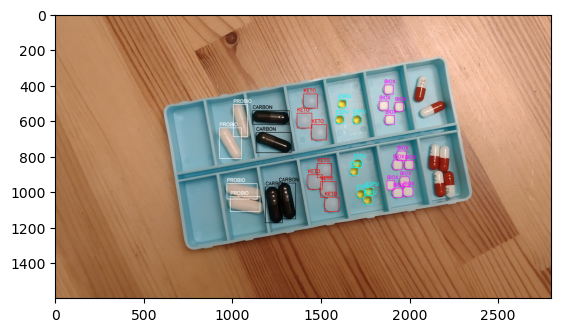

In [18]:
found = detect_objects(calib)
display_objects(calib, found)

### Test

Przetestuj swój algorytm na obrazie testowym `test.png` (lub `test_line.png`, jeśli podejmujesz się detekcji klasy LINE).
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

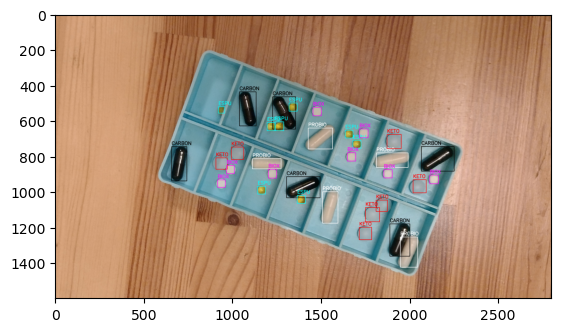

In [19]:
test = cv2.imread('Lab5_dane/test.png')
found = detect_objects(test)
display_objects(test, found)

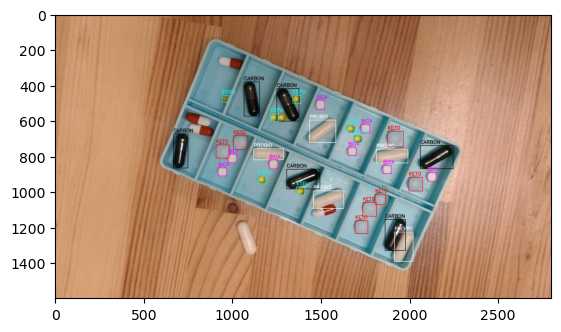

In [20]:
test = cv2.imread('Lab5_dane/test_line.png')
found = detect_objects(test)
display_objects(test, found)

---

### Zadanie dodatkowe - dla chętnych

Cel: zliczenie wystąpień leków w poszczególnych komórkach organizera.

Wykorzystaj transformację Hougha do wykrycia linii oddzielających komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
żadne szczegóły implementacyjne tej struktury nie są narzucone.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.